# word2vec demo of sentence similarity between a target phrase and some example sentences (as proxies for documents)

The goal is to show that Word2Vec (via https://radimrehurek.com/gensim/) can be used to score sentences against a target term to rank most-similar sentences towards the target. The dataset is Google's pre-trained vectors (https://code.google.com/archive/p/word2vec/) using Google News with 300 dimensions and approximately 100 billion words. Note that this model is trained on News data, which doesn't necessarily map to the Brands domain shown below (it is good enough for this proof of concept).

I've also drawn a T-SNE visualisation of word similarity for a selection of approximately 100 words. This might be a useful diagnostic.

Finally I show an old plot of similarity-stability when training on different vocabulary sizes, this is another diagnostic to test how well w2v has learned the underlying relationships (high stability means it has probably learned the underlying relationships to a higher fidelity). This shows what happens when we start to train our own datasets to replace the Google pre-built model with something suited to a particular domain (the stability example comes from 500,000 documents of recruitment data).

This is related to my [Data Science Delivered](https://github.com/ianozsvald/data_science_delivered) collection of notes.

License: CC-ByAttribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from gensim.models import word2vec

%matplotlib inline

/home/ian/anaconda/envs/scratch/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
if False:
    # start an interactive console 
    %qtconsole style=monokai

In [3]:
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib -g

2016-03-04 

CPython 3.4.4
IPython 4.1.1

numpy 1.10.4
matplotlib 1.5.1

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : b4987f7e8c882279d34e07c43cad29be86ccb6b2


In [4]:
# load w2v from pre-built Google data
w2v = word2vec.Word2Vec()
# download bin.gz from: https://code.google.com/archive/p/word2vec/
w2v = w2v.load_word2vec_format("/home/ian/data/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

w2v_vocab = set(w2v.vocab)

print("Loaded {} words in vocabulary".format(len(w2v_vocab)))

Loaded 3000000 words in vocabulary


In [5]:
# example of a similarity query, result in the range [0..1]
w2v.similarity("Pepsi", "Coke")

0.61606181393087323

## Make a similarity matrix for words and visualise

We can see that Coke-like words are more similar to each other than to Tech-Brand like words.

In [6]:
words = ["Coca_Cola", "Pepsi", "pepsi", "cola", "Microsoft", "Samsung", "Apple", "Google"]
similarities = np.zeros((len(words), len(words)), dtype=np.float_)
for idx1, word1 in enumerate(words):
    for idx2, word2 in enumerate(words):
        # note KeyError is possible if word doesn't exist
        sim = w2v.similarity(word1, word2)
        similarities[idx1, idx2] = sim
        
df = pd.DataFrame.from_records(similarities, columns=words)
df.index = words

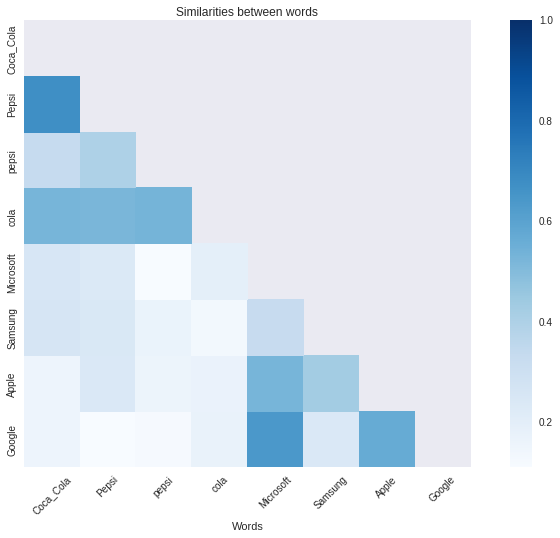

In [7]:
f, ax=plt.subplots(1, 1, figsize=(14,8))
cmap = plt.cm.Blues
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df, cmap=cmap, mask=mask, square=True, ax=ax)
_=plt.yticks(rotation=90)
plt.xlabel('Words')
_=plt.xticks(rotation=45)
_=plt.title("Similarities between words")

# we can see that pepsi/coke are similar and tech-brands are similar, but they're not similar between each group

## Score a target sentence to source sentences

Using word2vec's cosine similarity we can rank sentences by similarity to a target sentence. Using a mean-of-similarities approach is less robust (2nd example).

In [8]:
# example sentences (pretend these are from subtitles)
sentences = ["I'm happy to shop in Walmart and buy a Google phone",
             "In today's demo we'll look at Office and Word from microsoft",
             "Tech companies like Apple with their iPhone are the new cool",
             "Yesterday I went swimming",
             "Pepsi is drunk by a New Generation",
             "Bob has an Android Nexus 5 for his telephone", # Android and Google and 0.56 similar in this model
             "Alice drinks coffee every morning",
             "I want to drink a coke and eat something",
             "You'll be happier if you take a swim",
             "This is a really long sentence that hopefully doesn't get a very high score just because it has lots of words in it!"]

# here's a target we'd like to score against
#target_sentence = "You'd love to drink a cool refreshing Coke"
target_sentence = "Microsoft smartphones are the latest buzz"

In [9]:
# use n_similarity to compute a cosine similarity (should be reasonably robust)
sentences_similarity = np.zeros(len(sentences))

target_sentence_words = [w for w in target_sentence.split() if w in w2v_vocab]
for idx, sentence in enumerate(sentences):
    sentence_words = [w for w in sentence.split() if w in w2v_vocab]
    sim = w2v.n_similarity(target_sentence_words, sentence_words)
    sentences_similarity[idx] = sim

result = list(zip(sentences_similarity, sentences))
result.sort(key=lambda item:item[0], reverse=True)
print("Target:", target_sentence)
pprint.pprint(result)

# Show the target phrase and the most-similar target phrases

Target: Microsoft smartphones are the latest buzz
[(0.74686066803665185,
  'Tech companies like Apple with their iPhone are the new cool'),
 (0.51159241518507537, "I'm happy to shop in Walmart and buy a Google phone"),
 (0.50628555484687687, 'Bob has an Android Nexus 5 for his telephone'),
 (0.49553512193357013,
  "In today's demo we'll look at Office and Word from microsoft"),
 (0.48822586718911232,
  "This is a really long sentence that hopefully doesn't get a very high "
  'score just because it has lots of words in it!'),
 (0.45002837615820096, 'Pepsi is drunk by a New Generation'),
 (0.35430203629383683, "You'll be happier if you take a swim"),
 (0.27233323547177379, 'I want to drink a coke and eat something'),
 (0.26758033414210081, 'Alice drinks coffee every morning'),
 (0.20610100322639471, 'Yesterday I went swimming')]


In [10]:
# try a naive mean of scores method, this is far less robust
sentences_similarity = np.zeros(len(sentences))

for idx, sentence in enumerate(sentences):
    sentence_words = sentence.split()
    for word in sentence_words:
        sim_to_sentence = 0
        for target in target_sentence.split():
            try:
                sim_to_sentence += w2v.similarity(word, target)
            except KeyError:
                pass # ignore words that aren't in vocabulary
        sim_to_sentence /= len(sentence_words)
    sentences_similarity[idx] += sim_to_sentence


result = list(zip(sentences_similarity, sentences))
result.sort(key=lambda item:item[0], reverse=True)
print("Target:", target_sentence)
pprint.pprint(result)

Target: Microsoft smartphones are the latest buzz
[(0.085103496931917391, 'Alice drinks coffee every morning'),
 (0.082433348620532837, 'I want to drink a coke and eat something'),
 (0.070647013027927835,
  'Tech companies like Apple with their iPhone are the new cool'),
 (0.068455589789769275, 'Pepsi is drunk by a New Generation'),
 (0.064595146990399574, "I'm happy to shop in Walmart and buy a Google phone"),
 (0.058744101350012512,
  "In today's demo we'll look at Office and Word from microsoft"),
 (0.050154821482209774, 'Yesterday I went swimming'),
 (0.022989220321832104, 'Bob has an Android Nexus 5 for his telephone'),
 (0.014266848257751225, "You'll be happier if you take a swim"),
 (0.0,
  "This is a really long sentence that hopefully doesn't get a very high "
  'score just because it has lots of words in it!')]


## Test some word relationships

In [11]:
print(w2v['King'].shape) # 300 dimension vector for 1 word

(300,)


In [17]:
# classic king-man+woman=queen demo
w2v.most_similar(positive=["king", "woman"], negative=['man'])

[('queen', 0.7118192315101624),
 ('monarch', 0.6189675331115723),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.549946129322052),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098592638969421),
 ('monarchy', 0.5087412595748901)]

In [13]:
# we can ask for very similar terms
w2v.most_similar(positive=["Coca_cola"], negative=[])

[('Coca_Cola', 0.7633631825447083),
 ('Coco_Cola', 0.6657721400260925),
 ('CocaCola', 0.6073993444442749),
 ('Coke', 0.5985380411148071),
 ('Coca_Coca', 0.5932076573371887),
 ('Coke_Fanta', 0.5914841294288635),
 ('Sprite', 0.5718187093734741),
 ('coca_cola', 0.5708647966384888),
 ('soft_drink', 0.5536103248596191),
 ('Pepsi_cola', 0.5502616167068481)]

In [14]:
# cola and drink but not soft-drink is...
w2v.most_similar(positive=["Coke", "beverage"], negative=['soft_drink'])
# Diageo (UK spirits producer inc. Baileys, Moët Hennessy)
# Glacéau (enhanced water/energy drinks)

[('beverages', 0.5809513926506042),
 ('glacéau', 0.5346631407737732),
 ('Beverage', 0.5273338556289673),
 ('REVENUE_Rooms', 0.5152890086174011),
 ('Beverages', 0.5150997042655945),
 ('non_carbonated_beverage', 0.512222409248352),
 ('Coca_Cola', 0.5034570097923279),
 ('Glacéau', 0.4941721260547638),
 ('Diageo', 0.48930904269218445),
 ('Drinks', 0.48609596490859985)]

In [15]:
# a drink like coke but non-alcoholic
w2v.most_similar(positive=["Coke", "drink"], negative=['alcohol'])

[('Coca_Cola', 0.6385108828544617),
 ('soft_drink', 0.6031167507171631),
 ('Diet_Coke', 0.5739570260047913),
 ('Coca_cola', 0.5565926432609558),
 ('cola', 0.5564259886741638),
 ('Sprite', 0.5522558093070984),
 ('Vanilla_Coke', 0.5386818647384644),
 ('Glacéau', 0.5303133726119995),
 ('Hongli_Coal_&', 0.528174102306366),
 ('Coke_Fanta', 0.522808849811554)]

## Project a set of words (via their 300 dimensional vector) using T-SNE

T-SNE projects high dimensional feature spaces into 2D, we can then draw each word at its 2D location and colour by similarity to a target word.

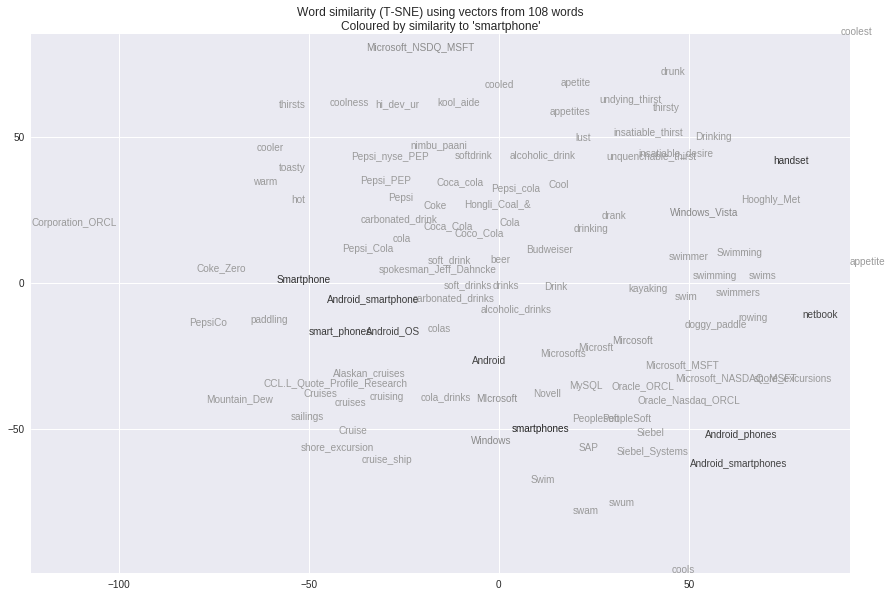

In [16]:
from sklearn.manifold import TSNE

raw_words_of_interest = ['Coke', 'Pepsi', 'cola', 'drink', 
                         'cool', 'swim', 'swimming', 'thirst', 
                         'Microsoft', 'Oracle',
                        'smartphone', 'cruise']
# some other random stuff we chould throw in...
#                    'King', 'Queen', 'person', 'walking', 'dancing', 'news', 'food', 'kitchen', 'house']

words_of_interest = []
for woi in raw_words_of_interest:
    for word, _ in w2v.most_similar(woi):
        words_of_interest.append(word)

words_of_interest = list(set(words_of_interest))

vectors = []
for word in set(words_of_interest):
    vectors.append(w2v[word])
    
vectors = np.vstack(vectors) # turn vectors into a 2D array <words x 300dim>

model = TSNE(n_components=2, random_state=0)
X_tsne = model.fit_transform(vectors)
df_after_tsne = pd.DataFrame.from_records(X_tsne, columns=['x', 'y'])
df_after_tsne['labels'] = words_of_interest

# calculate similarity from a target word to all words, to use as our colour
target_word = "smartphone"
similarities = []
for woi in words_of_interest:
    similarity = min(max(0, w2v.similarity(target_word, woi)), 1.0)
    similarities.append(similarity)

# plot the T-SNE layout for words, darker words means more similar to our target
plt.figure(figsize=(12,8))
plt.xlim((min(X_tsne[:,0]), max(X_tsne[:,0])))
plt.ylim((min(X_tsne[:,1]), max(X_tsne[:,1])))
for idx in range(X_tsne.shape[0]):
    x, y = X_tsne[idx]
    label = words_of_interest[idx]
    color=str(min(0.6, 1.0-similarities[idx])) # convert to string "0.0".."1.0" as greyscale for mpl
    plt.annotate(s=label, xy=(x, y), color=color)
    #plt.annotate(s=label, xy=(x, y), weight=int(similarities[idx]*1000)) # use weight
plt.tight_layout()

_=plt.title("Word similarity (T-SNE) using vectors from {} words\nColoured by similarity to '{}'".format(len(words_of_interest), target_word))

# Next steps

* Try doc2vec (need to train on fresh data) https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb
* Train on data relevant to the domain    
* On training, consider how adding more of the right terms rapidly gets us to a stable similarity measure e.g. Nexus is unknown by this trained set as being related to Android so it does poorly in matching a Nexus sentence to Microsoft

This example shows how adding more sentence examples (i.e. Moar Data!) to 5 model rebuilds causes greater stability (more similar similarity measures) ([original tweet](https://twitter.com/ianozsvald/status/611581722426216448?cn=cmVwbHk%3D&refsrc=email)):

![scaling](https://pbs.twimg.com/media/CHzGVebXAAAsuXH.png) 

